# Twitch network analysis

The Twitch social network composes of users. A small percent of those users broadcast their gameplay or activities through live streams. In the graph model, users who do live streams are tagged with a secondary label Stream. Additional information about which teams they belong to, which games they play on stream, and in which language they present their content is present. You also know how many followers they had at the moment of scraping, the all-time historical view count, and when they created their user account. The most relevant information for network analysis is knowing which users engaged in the streamer’s chat. You can distinguish if the user who chatted in the stream was a regular user (CHATTER relationship), a moderator of the stream (MODERATOR relationship), or a VIP of the stream.

The network information was scraped between the 7th and the 10th of May 2021.

In [1]:
# Import Libraries
%matplotlib inline
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
# Visual
sns.set(font_scale = 1.5)
sns.color_palette("hls", 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000) # Enables Pandas to display long strings properly

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Connect to Neo4j
driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'letmein'))

def read_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

# Exploratory graph analysis
Before diving into graph algorithms, I will want to be acquainted with the graph first.
An exploratory graph analysis be done by executing a couple of Cypher queries to learn more about the network. All bar charts in this notebook are created with the help of the Seaborn library. To begin, we will retrieve the top ten streamers by all-time historical view count.

In [5]:
# Reading database on its labels and properties
read_query("""
CALL apoc.meta.stats()
YIELD labels;
""")

,labels
0,"{'Game': 594, 'User': 4678779, 'Language': 29, 'Stream': 4540, 'Team': 1468}"


In this database, almost all nodes are users. There are 4678779 users and only 4540 of them are streamers. These streamers have played 594 games and broadcasted in 29 different languages. Data was scraped between the 7th and the 10th of May 2021.

In [ ]:
read_query("""
CALL apoc.meta.graphSample()
""")

![title](img/data_schema.png)

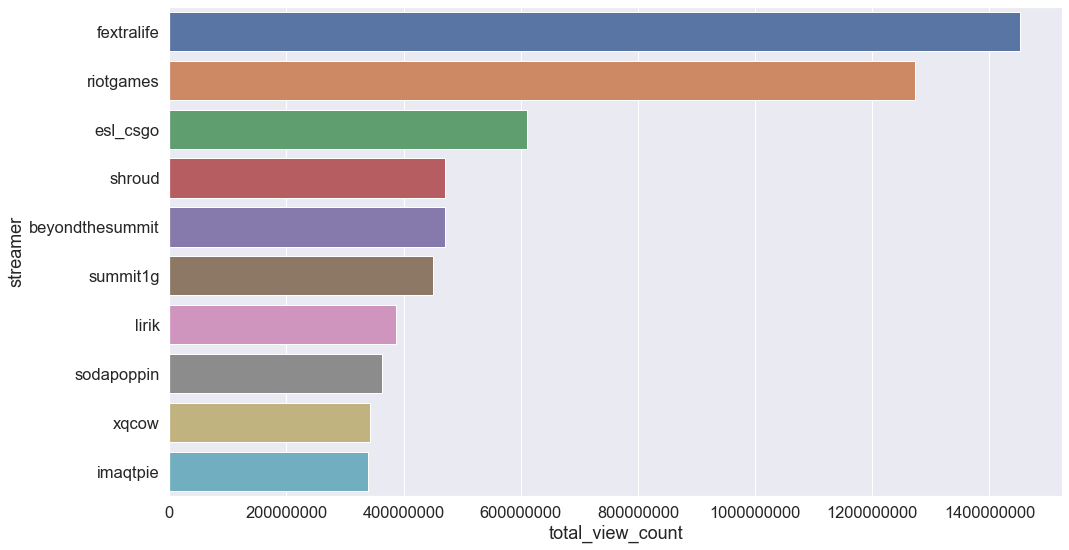

In [5]:
data = read_query("""
MATCH (u:Stream)
WHERE exists(u.total_view_count)
RETURN u.name as streamer,
       u.total_view_count as total_view_count
ORDER BY total_view_count DESC
LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(y="streamer", x="total_view_count", data=data)
ax.ticklabel_format(style='plain', axis='x');
#ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

The above bar plot shows Twitch streamers who have live-streamed between the 7th and the 10th of May. There might be other streamers that have higher all-time view counts. The top three all-time view count streamers in this plot seems to be from an organisations or team, whereas the other 7 streamers down the row are individuals. Since the top three streamers do seem to be from an organisation or team, the subsequent queries is to find out if there are variations of the same name.

In [6]:
# finding out variations for node name
read_query("""
MATCH (a:Stream{name: "fextralife"})
MATCH (b:Stream) where b.name <> a.name

WITH a, b, apoc.text.clean(a.name) AS norm1, apoc.text.clean(b.name) AS norm2
WITH toInteger(apoc.text.jaroWinklerDistance(norm1, norm2) * 100) AS similarity, a, b
WITH a, b,similarity where similarity >= 80 
RETURN a.name AS aname, b.name AS bname, similarity
""")

,aname,bname,similarity


Upon further research, the streamer "fextralife" are a team of different people, taking turns to stream different genres of games.

In [7]:
# finding out variations for node name
read_query("""
MATCH (a:Stream{name: "riotgames"})
MATCH (b:Stream) where b.name <> a.name

WITH a, b, apoc.text.clean(a.name) AS norm1, apoc.text.clean(b.name) AS norm2
WITH toInteger(apoc.text.jaroWinklerDistance(norm1, norm2) * 100) AS similarity, a, b
WITH a, b,similarity where similarity >= 80 
RETURN a.name AS aname, b.name AS bname, similarity
""")

,aname,bname,similarity
0,riotgames,f1ninogames,80
1,riotgames,riotgamesjp,96
2,riotgames,riotgamesturkish,91
3,riotgames,riotgamesru,96


The results in the above table shows that there are 4 results. Only "f1ninogames" will not be considered to have any relations to "riotgames" because of the naming convention, as the other results suggest that they are different channels from the same company to cater for language differences. 

In [ ]:
read_query("""
MATCH (u:Stream{name:'riotgames'})-[r]->(b)
RETURN u,r,b
""")

![title](img/riotgames.png)

With the above qurey, the node 'riotgames' has 3 types of relationships. 
1) 2 of which are under 'HAS_TEAM' to Riot games and League of Legends Championship Series. 
2) 'HAS_LANGUAGE' is connected to English
3) 'PLAYS' is towards League of Legends

Lets see if the other nodes of similar names under Riot Games would produce the same results.

In [ ]:
read_query("""
WITH ['riotgames','riotgamesjp','riotgamesturkish','riotgamesru'] AS riot
MATCH (u:Stream)-[r]->(b)
WHERE u.name IN riot
RETURN u,r,b
""")

![title](img/riotgames2.png)

As predicited, the other streamers that has 'riotgames' naming convention leads to their unique language relationships. All nodes under riotgames also has relationship towards League of Legends. However, there are some inconsistencies on "HAS_TEAM" for the nodes riotgames nodes. Riot Games also owns other games like Valorant, but League of Legends only shows up. This is because from the 7th to the 10th of May, a tournement was happening. The following code shows the total viewer count from all 4 users.

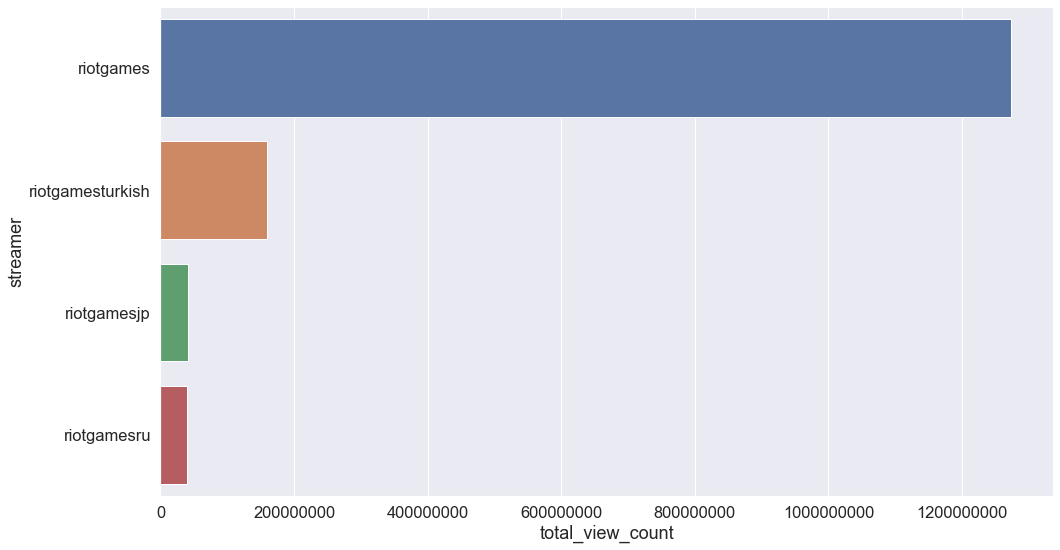

In [10]:
data = read_query("""
WITH ['riotgames','riotgamesjp','riotgamesturkish','riotgamesru'] AS riot
MATCH (a:Stream)
WHERE a.name IN riot
RETURN a.name as streamer,
       a.total_view_count as total_view_count
ORDER BY total_view_count DESC;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(y="streamer", x="total_view_count", data=data)
ax.ticklabel_format(style='plain', axis='x');

Now, lets take a look at ESL, another organization that manages tournements for CSGO, Counter Strike Global Offensive. A similar approach will be done for ESL, where I find the node relationships, the variation of its name, and compare those node relationships to the main node.

In [ ]:
read_query("""
MATCH (u:Stream{name:'esl_csgo'})-[r]->(b)
RETURN u,r,b
""")

![title](img/esl_csgo.png)

esl_csgo has many more team relationships, but only plays 1 game and has only 1 language. At that point of time from 7 to 10 May, ESL also had an tournement, lets see if there are other channels that have similar relationships.

In [12]:
# finding out variations for node name
read_query("""
MATCH (a:Stream{name: "esl_csgo"})
MATCH (b:Stream) WHERE b.name <> a.name

WITH a, b, apoc.text.clean(a.name) AS norm1, apoc.text.clean(b.name) AS norm2
WITH toInteger(apoc.text.jaroWinklerDistance(norm1, norm2) * 100) AS similarity, a, b
WITH a, b,similarity WHERE similarity >= 80 
RETURN a.name AS aname, b.name AS bname, similarity
""")

,aname,bname,similarity
0,esl_csgo,esl_csgo_fr,95
1,esl_csgo,esl_wc3,82
2,esl_csgo,esl_csgo_pl,95
3,esl_csgo,tes_csgo,90
4,esl_csgo,esl_pov1,80
5,esl_csgo,esl_csgob_pl,94
6,esl_csgo,esl_sc2,84
7,esl_csgo,mslcsgo,90
8,esl_csgo,esl_pov2,80
9,esl_csgo,esl_pov6,80


For this query, more results are shown. Majority of the result either shows that they are catering to a different language. However, mslcsgo is not part of any organisation, and its an individual that streams, thus will be removed from comparisions. esl_wc3 and esl_sc2 have the main organisation's acronym, however, at the end of the user name, it is completely different as compared to "esl_csgo". These 2 users are catering to a different game in this case, Warcraft 3 and Starcraft 2 respectively. Upon further researching, esbcsgo1 is on its own entity, where the streams from this user are of different ruleset and different tourney. 

In [ ]:
read_query("""
WITH ['esl_csgo_fr', 'esl_csgo_pl','esl_csgo','esl_pov1','esl_csgob_pl','esl_pov2','esl_pov6'] AS esl
MATCH (u:Stream)-[r]->(b)
WHERE u.name IN esl
RETURN u,r,b
""")

![title](img/esl_csgo2.png)

Same characteristics as what Riot Games had, where nodes are inconsistent in relationships to teams, however, the common theme here is that they are connected to the same game, and its own respective language. It is interesting to see that there are 2 nodes that are meant for english, yet those users that streams for the english audience are not connected to both at the same time. Now, lets take a look at the total view count.


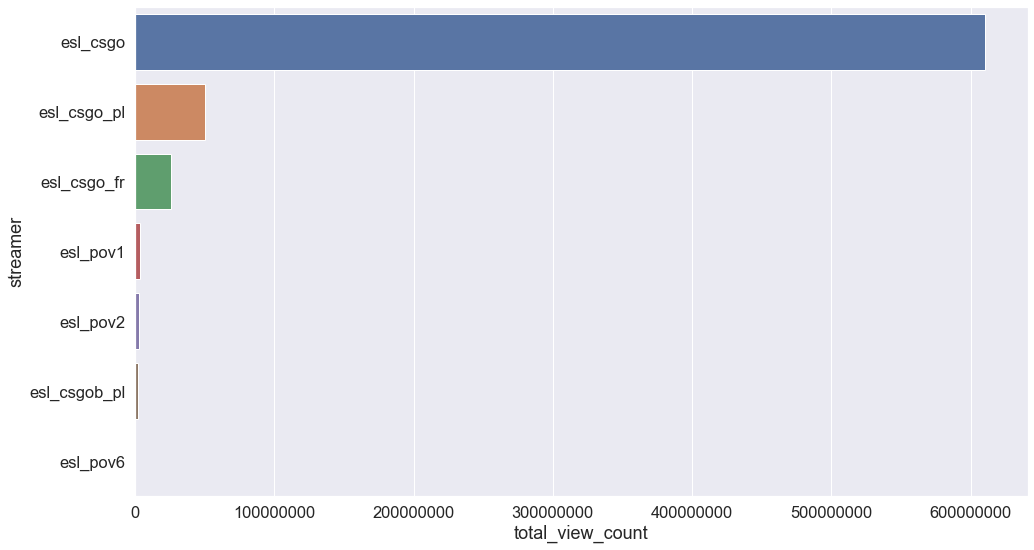

In [14]:
data = read_query("""
WITH ['esl_csgo_fr', 'esl_csgo_pl','esl_csgo','esl_pov1','esl_csgob_pl','esl_pov2','esl_pov6'] AS esl
MATCH (a:Stream)
WHERE a.name IN esl
RETURN a.name as streamer,
       a.total_view_count as total_view_count
ORDER BY total_view_count DESC;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(y="streamer", x="total_view_count", data=data)
ax.ticklabel_format(style='plain', axis='x');

Similar characteristics as compared to Riot Games, where the main user has the most amount of viewer count. I would like to point out that esl_pov1, esl_pov2 and esl_pov6 are probably slightly different from the main stream, where player's point of view are streamed from these users, and only select few individuals would be interested in them. I will now move onto follower count.

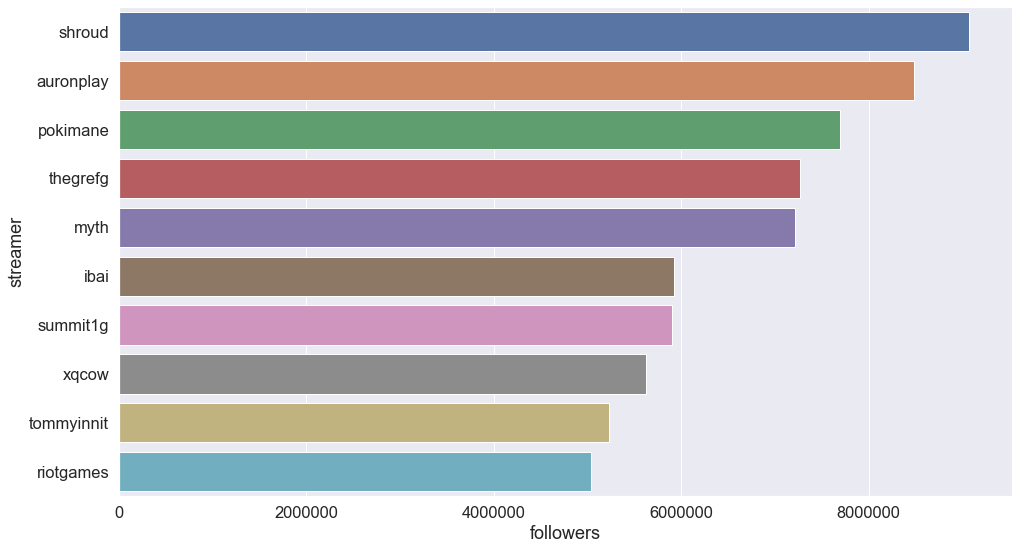

In [15]:
data = read_query("""
MATCH (u:Stream)
WHERE exists(u.followers)
RETURN u.name as streamer,
       u.followers as followers
ORDER BY followers DESC
LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="followers", y="streamer", data=data)
ax.ticklabel_format(style='plain', axis='x');
#ax.set_yticklabels(ax.get_yticklabels(), rotation=30)

The results shown above are a different group of streamers, as compared to the viewer count query. Except for Shroud, he is fourth in the all-time view count category and second in the highest follower count. Riot Games made into this list, while esl_csgo did not. Even though both of these channels have high viewer count during these days, they do not have high followers. The reason for this is because users are only interested to tune in when there is an on going tournement. On Twitch, having to "follow" a streamer will give you notifications when they are live. Since ESL and Riot Games are bigger organisations, there would be other source of annoucements on other platforms. Now, we will move into aggregating the count of streams by their user creation date.

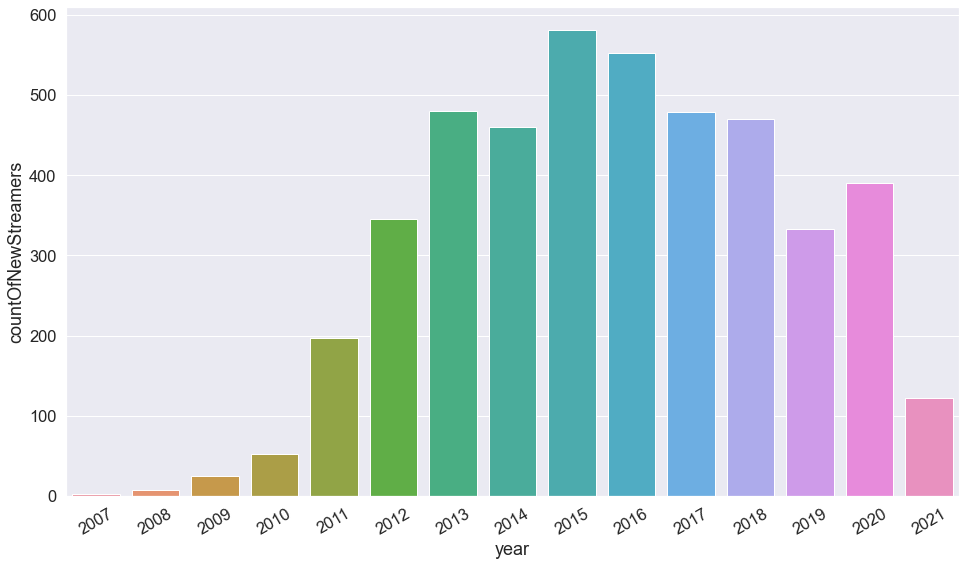

In [16]:
data = read_query("""
MATCH (u:Stream)
WHERE exists(u.createdAt)
RETURN u.createdAt.year as year,
       count(*) as countOfNewStreamers
ORDER BY year;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="year", y="countOfNewStreamers", data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

The aggregation done here is by the date of when the user account was created and not when they first started streaming. Unfortunately, the date of the user's first stream is not available in this database. Judging by the results, at least some of the streamers have already a ten-year career on Twitch. We can move away from the streamers and investigate which games are played by most streamers. Note that a streamer can play more than a single game, so they might be counted under multiple games. Our data was collected between Friday and Sunday, so a streamer might prefer to play Valorant on Friday and Poker on Sunday.

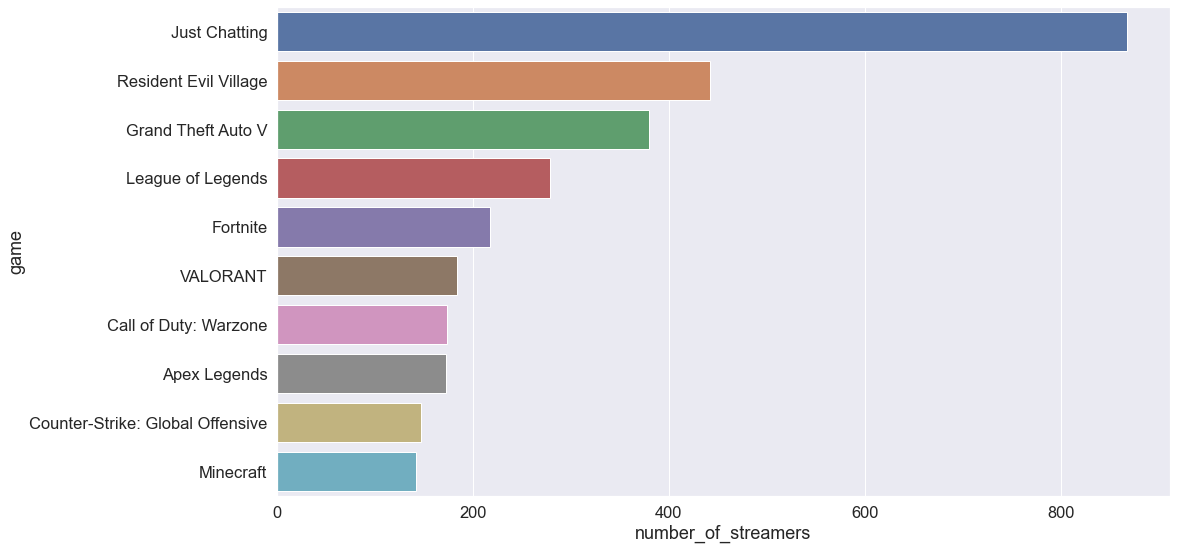

In [17]:
data = read_query("""
MATCH (g:Game)
RETURN g.name as game,
       size((g)<--()) as number_of_streamers
ORDER BY number_of_streamers DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(y="game", x="number_of_streamers", data=data);
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

The most popular is the Just Chatting category. The cause of the Just Chatting category popularity might be due to the reason that it is used for all streams that don't play a specific video game. This might include anything from cooking shows to "In real life" streams, where the streamer is walking around the world with a camera in hand. The reason why there is an high amount of streamers that are playing Resident Evil Village is because, that game was released on the 2nd May 2021. Since it is a new game, there is hype around the game and people will want to play it. Next up, we have Grand Theft Auto V. Even though it was released in the 2013, there was a short period of time where streamers collaborated together for content creation, where they hosted servers to have "role-play" in them. The subsequent games down the list are popular games that people play these days.